In [1]:
import os
import ember

import numpy as np
import pandas as pd
import altair as alt
import lightgbm as lgb
import matplotlib.pylab as plt
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

### Creating the baseline model

In [ ]:
ember.create_vectorized_features("data/ember2018/")
ember.create_metadata("data/ember2018/")

In [8]:
%%time
X_train, y_train, X_test, y_test = ember.read_vectorized_features("data/ember2018/")
emberdf = ember.read_metadata("data/ember2018/")
emberdf

Wall time: 1.23 s


,sha256,appeared,label,avclass,subset
0,0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...,2006-12,0,NaN,train
1,c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...,2007-01,0,NaN,train
2,eac8ddb4970f8af985742973d6f0e06902d42a3684d791...,2007-02,0,NaN,train
3,7f513818bcc276c531af2e641c597744da807e21cc1160...,2007-02,0,NaN,train
4,ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...,2007-02,0,NaN,train
...,...,...,...,...,...
999995,e033bc4967ce64bbb5cafdb234372099395185a6e0280c...,2018-12,1,zbot,test
999996,c7d16736fd905f5fbe4530670b1fe787eb12ee86536380...,2018-12,1,flystudio,test
999997,0020077cb673729209d88b603bddf56b925b18e682892a...,2018-12,0,NaN,test
999998,1b7e7c8febabf70d1c17fe3c7abf80f33003581c380f28...,2018-12,0,NaN,test


# Performing EDA on the vectorized data

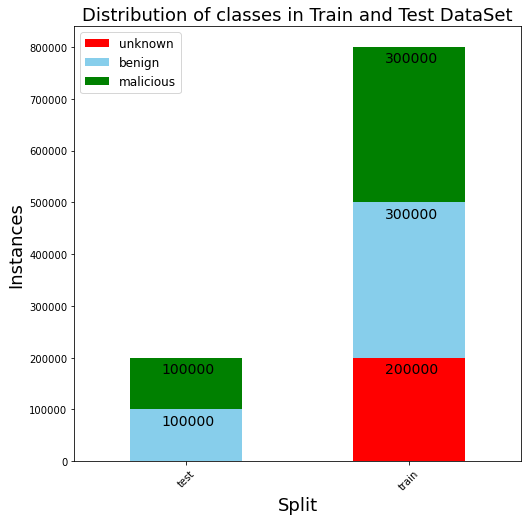

In [3]:
stack = emberdf.pivot_table(index='subset', columns='label',values='appeared',aggfunc='count')
stack.columns = ['unknown','benign','malicious']
ax = stack.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'],figsize=(8,8))
for i in range(2):
    s= 0
    for j in range(3):
        if i==0 and j==0:
            continue
        s+=stack.iloc[i,j]
        ax.annotate(int(stack.iloc[i,j]), (i-0.11,s-30000),fontsize= 14)

plt.xlabel('Split',fontsize= 18)
plt.ylabel('Instances',fontsize= 18)
plt.rc('xtick',labelsize=18)
plt.xticks(rotation=45)
plt.title('Distribution of classes in Train and Test DataSet',fontsize= 18)
plt.legend(fontsize=12)
plt.show()

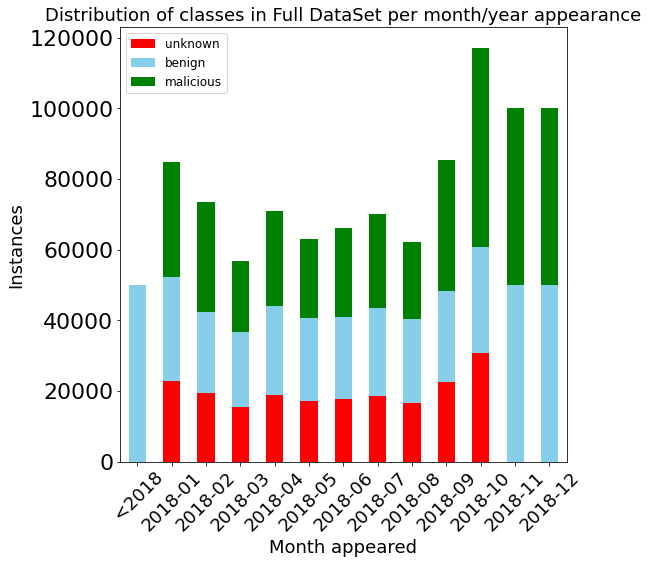

In [17]:
stack = emberdf.copy()
stack.loc[stack["appeared"] < "2018-01", "appeared"] = " <2018"
stack = stack.pivot_table(index='appeared', columns='label',values='sha256',aggfunc='count')
stack.columns = ['unknown','benign','malicious']
ax = stack.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'],figsize=(8,8))
# for i in range(2):
#     s= 0
#     for j in range(3):
#         if i==0 and j==0:
#             continue
#         s+=stack.iloc[i,j]
#         ax.annotate(int(stack.iloc[i,j]), (i-0.11,s-30000),fontsize= 14)

plt.xlabel('Month appeared',fontsize= 18)
plt.ylabel('Instances',fontsize= 18)
plt.rc('xtick',labelsize=18)
plt.xticks(rotation=45)
plt.title('Distribution of classes in Full DataSet per month/year appearance',fontsize= 18)
plt.legend(fontsize=12)
plt.show()

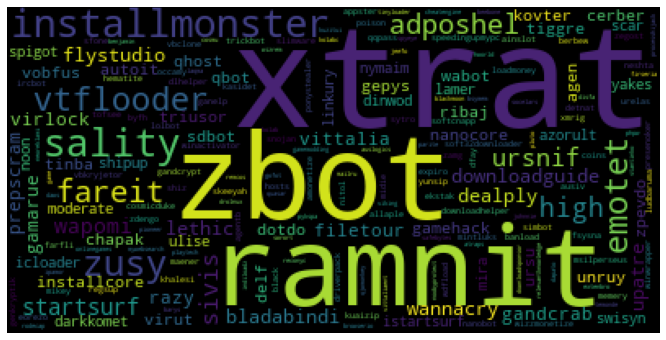

In [4]:
tex = emberdf['avclass'][emberdf['avclass'].notna()].values 
plt.figure(figsize=(15,6))
text = " ".join(title for title in tex)
wordcloud = WordCloud(collocations = False, background_color = 'black').generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

AVClass is Python tool to tag / label malware samples.


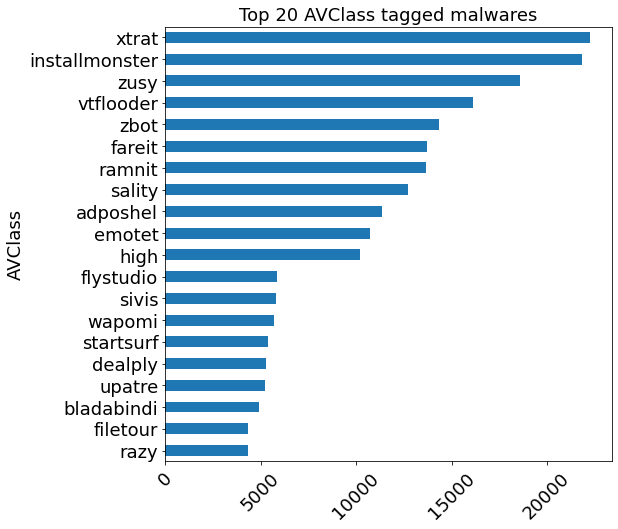

In [6]:
# malicious classification via AVClass
n = 20 #top N tagged malwares
a,b = np.unique(emberdf[emberdf.subset=='train'].avclass.dropna().values,return_counts = True)
d = {}
for i,j in zip(a,b):
    d[i] = j
mal_clus = pd.Series(d)
mal_clus.nlargest(n).sort_values(ascending=True).plot(kind='barh',figsize=(8,8))
plt.ylabel('AVClass',fontsize= 18)
plt.rc('ytick',labelsize=22)
plt.xticks(rotation=45)
plt.title(f'Top {n} AVClass tagged malwares',fontsize= 18)
plt.show()

---

In [ ]:
data_dir = "data/ember2018/"

In [ ]:
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))

In [ ]:
y_test_pred = lgbm_model.predict(X_test)
y_train_pred = lgbm_model.predict(X_train)
emberdf["y_pred"] = np.hstack((y_train_pred, y_test_pred))

In [ ]:
def get_fpr(y_true, y_pred):
    nbenign = (y_true == 0).sum()
    nfalse = (y_pred[y_true == 0] == 1).sum()
    return nfalse / float(nbenign)


def find_threshold(y_true, y_pred, fpr_target):
    thresh = 0.0
    fpr = get_fpr(y_true, y_pred > thresh)
    while fpr > fpr_target and thresh < 1.0:
        thresh += 0.0001
        fpr = get_fpr(y_true, y_pred > thresh)
    return thresh, fpr

testdf = emberdf[emberdf["subset"] == "test"]
print("ROC AUC:", roc_auc_score(testdf.label, testdf.y_pred))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.01)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
print("Ember Model Performance at 1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.001)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
print("Ember Model Performance at 0.1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))

In [ ]:
plt.figure(figsize=(8, 8))
fpr_plot, tpr_plot, _ = roc_curve(testdf.label, testdf.y_pred)
plt.plot(fpr_plot, tpr_plot, lw=4, color='k')
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.ylim([0.65, 1.01])
plt.gca().grid(True)
plt.vlines(fpr, 0, 1 - fnr, color="r", lw=2)
plt.hlines(1 - fnr, 0, fpr, color="r", lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
_ = plt.title("Ember Model ROC Curve")

In [ ]:
import sklearn.ensemble as ske

In [ ]:
# Scaling the features in order to improve the performance of the model
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()

In [ ]:
Xtrain_rs = rs.fit_transform(X_train)
Xtest_rs = rs.fit_transform(X_test)

In [ ]:
%%time

adaBoost =ske.AdaBoostClassifier(n_estimators=3).fit(Xtrain_rs, np.array(y_train))

adaBoostScore = adaBoost.score(np.array(Xtest_rs), np.array(y_test))
print(f"Accuracy score: {adaBoostScore*100: .3f}%")

In [ ]:
%%time
# Import Support Vector Classifier
from sklearn.svm import SVC
from sklearn import metrics
#Import scikit-learn metrics module for accuracy calculation
svc=SVC(probability=True, kernel='linear')

# Create adaboost classifer object
adaBoost =ske.AdaBoostClassifier(n_estimators=8,base_estimator=svc,learning_rate=1).fit(Xtrain_rs, np.array(y_train))

adaBoostScore = adaBoost.score(np.array(Xtest_rs), np.array(y_test))
print(f"Accuracy score: {adaBoostScore*100: .3f}%")

y_pred = adaBoost.predict(np.array(Xtest_rs))


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import json
import ember
import csv


import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [ ]:
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [ ]:
train_rows = y_train >=0
print(train_rows.size)
print(train_rows[500000])

In [ ]:
n_inputs = 2381

print("Building neural network")
model = Sequential()
model.add(Dense(30, input_shape=(n_inputs,), activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(70, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='tanh'))

print("Compiling neural network")
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# checkpath = os.path.join(os.path.dirname(os.path.abspath('')), "checkpoints")
# os.makedirs(checkpath, exist_ok=True)
checkpath = os.path.join('checkpoints/', 'model-epoch{epoch:03d}-acc{val_acc:03f}.h5')

stopper = EarlyStopping(monitor = 'val_acc', min_delta=0.0001, patience = 5, mode = 'auto')

saver = ModelCheckpoint(checkpath, save_best_only=True, verbose=1, monitor='val_loss', mode='min')

print("Training neural network...")
# train the model
#! error with validation_data shape..
fitted_model = model.fit(X_train[train_rows], y_train[train_rows],
          epochs=5,
          verbose=2, 
          validation_data=(X_test, y_test)
         )

In [ ]:
fitted_model.evaluate(X_test, y_test)

In [ ]:
y_binary = to_categorical(y_test)
print(y_binary.shape)

In [ ]:
y_binary

In [ ]:
model.evaluate(X_test, y_test)